In [1]:
import sys

sys.path.append(".")

from analysis.dhg_analysis import (process_spectral_data_to_image, merge_mzs_and_intensities)

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

"""Function containing main code"""
# Define current folder using this file
CWD = Path(".")
# Define folder that contains dataset
LONGITUDINAL_PATH = CWD / ".." / "data" / "LONGITUDINAL"
# Define folder that contains raw data
RAW_DATA = LONGITUDINAL_PATH / "raw_txt"
# Define folder to save processed data
PROCESSED_DATA = LONGITUDINAL_PATH / "processed_txt"
# Define file that contains metadata
METADATA_PATH = LONGITUDINAL_PATH / "txt_metadata.csv"
# Define path to save plots and results
FIGURES_PATH = CWD / "longitudinal"
FIGURES_PATH.mkdir(exist_ok=True, parents=True)
# Define mass resolution of the data
MASS_RESOLUTION = 0.02

In [7]:
from processing import TICNormalizer
from skimage import filters
from skimage.morphology import disk
from scipy import ndimage

# Create a normalizer
normalizer = TICNormalizer()
# Get the aw files
raw_files = list(Path(RAW_DATA).iterdir())
# Create a dictionary to store the images
imgs = {}
# Create a dictionary to store the segmented images
tissue_seg = {}

# Loop through the files
for p in raw_files:
  # Get image and mzs
  img, mzs = process_spectral_data_to_image(p)
  # Apply normalization to the intensities
  img_norm = np.apply_along_axis(
      lambda intensities: (normalizer.normalize((mzs, intensities)))[1],
      axis=2, arr=img
  )
  # Merge mz channels with difference less than 0.02 as they are likely to be
  # the same mz
  mzs_merged, img_norm_merged = merge_mzs_and_intensities(
      mzs, img_norm, threshold=MASS_RESOLUTION
  )

  # Apply segmentation
  thresh = 75

  gray_matter_mzs_filter = (
      (mzs_merged >= 600.51 - MASS_RESOLUTION * 2) &
      (mzs_merged <= 600.51 + MASS_RESOLUTION * 2)
  )
  white_matter_mzs_filter = (
    (mzs_merged >= 888.62 - MASS_RESOLUTION * 2) &
    (mzs_merged <= 888.62 + MASS_RESOLUTION * 2)
  )
  tumour_mzs_filter = (
    (mzs_merged >= 682.59 - MASS_RESOLUTION * 2) &
    (mzs_merged <= 682.59 + MASS_RESOLUTION * 2)
  )

  img_smooth = filters.gaussian(img_norm_merged, sigma=0.5)

  gray_matter_img = img_norm_merged[:,:, gray_matter_mzs_filter].sum(axis=2)
  white_matter_img = img_norm_merged[:,:, white_matter_mzs_filter].sum(axis=2)
  tumour_img = img_norm_merged[:,:, tumour_mzs_filter].sum(axis=2)

  smooth_gray_matter_img = filters.gaussian(gray_matter_img, sigma=1)
  smooth_white_matter_img = filters.gaussian(white_matter_img, sigma=1)
  smooth_tumour_img = filters.gaussian(tumour_img, sigma=1)

  gray_matter_img_thresh = smooth_gray_matter_img >= np.percentile(
       smooth_gray_matter_img.flatten(), 80
  )
  white_matter_img_thresh = smooth_white_matter_img >= np.percentile(
      smooth_white_matter_img.flatten(), 85
  )
  tumour_img_thresh = smooth_tumour_img >= np.percentile(
      smooth_tumour_img.flatten(), 85
  )

  img_segmented = gray_matter_img_thresh + white_matter_img_thresh + tumour_img_thresh

  tissue_seg[p.stem] = filters.median(ndimage.binary_fill_holes(img_segmented), disk(5))

  # Save the image
  from sklearn.preprocessing import MinMaxScaler
  img_norm = np.zeros_like(img_smooth)
  img_norm[img_segmented] = MinMaxScaler(clip=True).fit_transform(img_smooth[img_segmented])
  imgs[p.stem] = img_norm

In [8]:
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering

def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering

segmentations = {}

for key, img in tqdm(imgs.items()):
  # Get the pixels
  pixels = img[tissue_seg[key]]
  # Perform hierarchical clustering
  clustering = perform_hierarchical_clustering(pixels, 3)
  # Get the labels
  labels = np.zeros(img.shape[:2], dtype=np.uint8)
  labels[tissue_seg[key]] = clustering.labels_ + 1
  labels = labels.reshape(img.shape[:2])
  # Save the labels
  segmentations[key] = labels

100%|██████████| 12/12 [00:42<00:00,  3.53s/it]


In [9]:
cluster_labels_map = {"white": 1, "gray": 2 , "tumour": 3}

# No image smoothing
color_map = {
 '20240425_B4_T_0_S1(Day0S2)_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240425_B4_T_1000_S1(Day0S3)_Rep2_600-900_TopMax': {1: "tumour", 2: "white", 3: "gray"},
 '20240510_B5_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
 '20240510_B5_T_1000_S2(Day0S3)_Rep3_600-900_TopMax': {1: "tumour", 2: "gray", 3: "white"},
 '20240425_B4_T_Day0_Rep2_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
 '20240521_B8_R_T_1000_S1(Day0S2)_Rep2_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
 '20240514_B8_R_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240425_B4_T_Day0_Rep3_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240510_B5_T_Day0_Rep1_600-900_TopMax': {1: "gray", 2: "tumour", 3: "white"},
  '20240510_B5_T_Day0_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
  '20240523_B8_R_T_Day0_Rep2_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240523_B8_R_T_Day0_Rep1_600-900_TopMax': {1: "tumour", 2: "white", 3: "gray"}
}

# Gaussian smoothing with sigma=0.5
color_map = {
 '20240425_B4_T_0_S1(Day0S2)_Rep3_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
 '20240425_B4_T_1000_S1(Day0S3)_Rep2_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
 '20240510_B5_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240510_B5_T_1000_S2(Day0S3)_Rep3_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
 '20240425_B4_T_Day0_Rep2_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240521_B8_R_T_1000_S1(Day0S2)_Rep2_600-900_TopMax': {1: "gray", 2: "tumour", 3: "white"},
 '20240514_B8_R_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240425_B4_T_Day0_Rep3_600-900_TopMax': {1: "tumour", 2: "gray", 3: "white"},
  '20240510_B5_T_Day0_Rep1_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240510_B5_T_Day0_Rep3_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
  '20240523_B8_R_T_Day0_Rep2_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
  '20240523_B8_R_T_Day0_Rep1_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"}
}

# Gaussian smoothing with sigma=1
color_map = {
 '20240425_B4_T_0_S1(Day0S2)_Rep3_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
 '20240425_B4_T_1000_S1(Day0S3)_Rep2_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240510_B5_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240510_B5_T_1000_S2(Day0S3)_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
 '20240425_B4_T_Day0_Rep2_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
 '20240521_B8_R_T_1000_S1(Day0S2)_Rep2_600-900_TopMax': {1: "tumour", 2: "white", 3: "gray"},
 '20240514_B8_R_T_0_S1(Day0S1)_Rep3_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
  '20240425_B4_T_Day0_Rep3_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"},
  '20240510_B5_T_Day0_Rep1_600-900_TopMax': {1: "white", 2: "tumour", 3: "gray"},
  '20240510_B5_T_Day0_Rep3_600-900_TopMax': {1: "gray", 2: "tumour", 3: "white"},
  '20240523_B8_R_T_Day0_Rep2_600-900_TopMax': {1: "gray", 2: "white", 3: "tumour"},
  '20240523_B8_R_T_Day0_Rep1_600-900_TopMax': {1: "white", 2: "gray", 3: "tumour"}
}

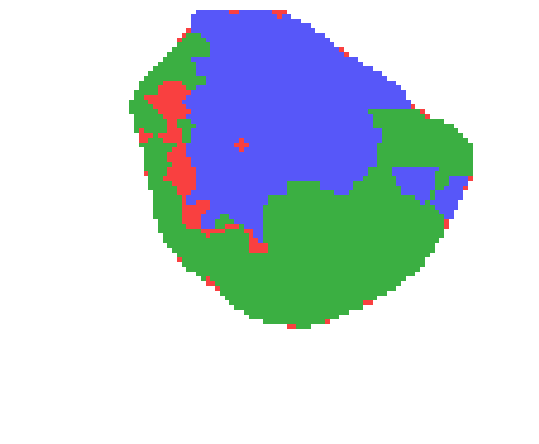

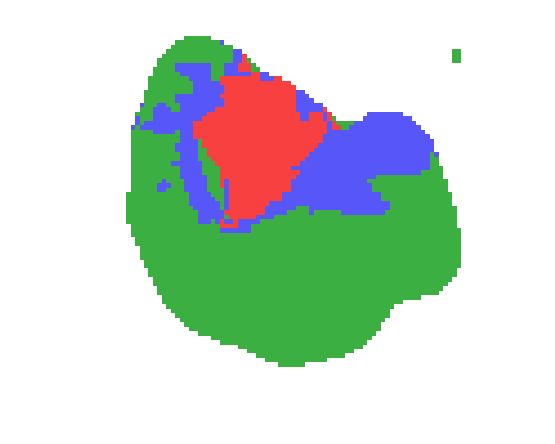

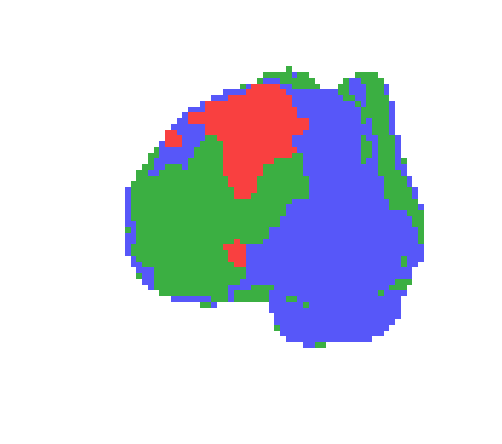

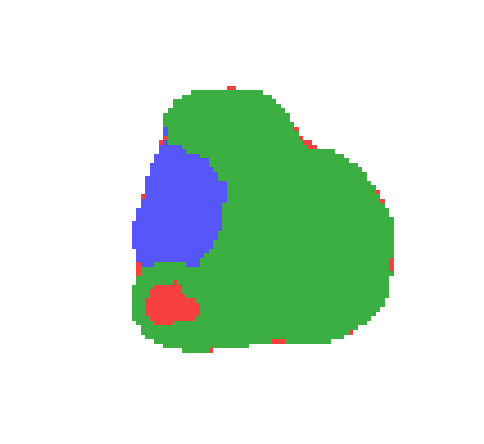

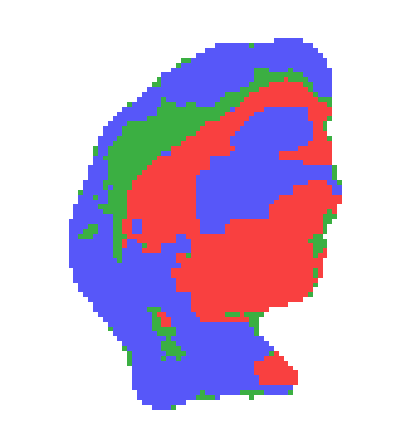

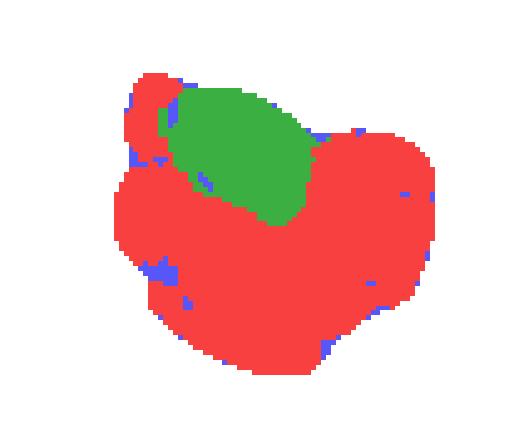

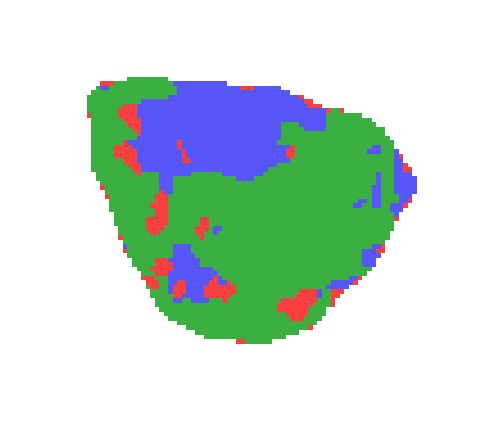

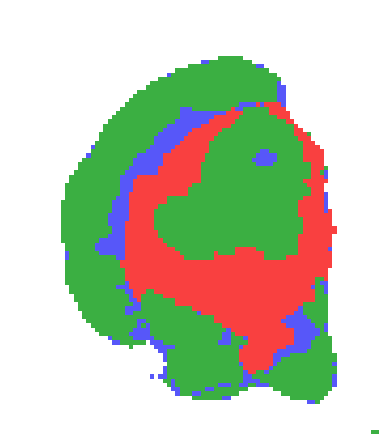

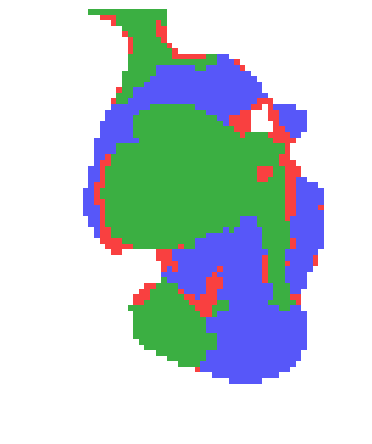

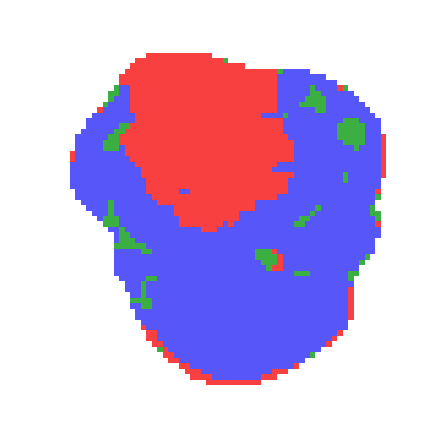

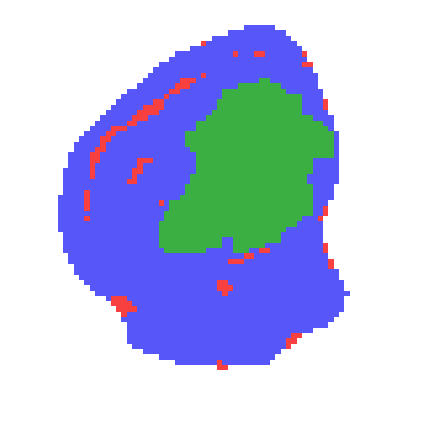

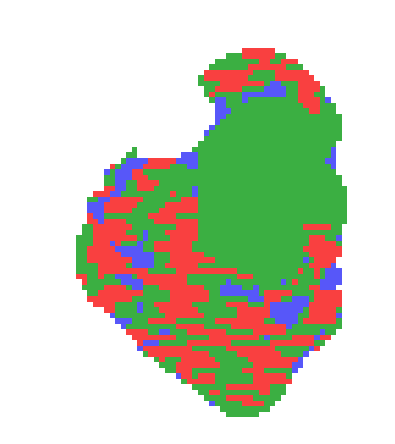

In [10]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap([(1, 1, 1, 0), "#3BAF42", "#5757F9", "#F94040"])


for key, seg in segmentations.items():
  #
  color_img = np.zeros(seg.shape, dtype=np.uint8)
  for cluster, color in color_map[key].items():
    color_img[seg == cluster] = cluster_labels_map[color]

  # Save the segmentation
  plt.imshow(color_img, cmap=cmap)
  plt.tight_layout()
  plt.axis("off")
  plt.savefig(FIGURES_PATH / f"{key}_segmentation.png", dpi=1200, bbox_inches="tight", transparent=True)
  plt.show()